In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Sun Jan 21 23:27:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.rand_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 10
hp.N = 256
hp.n_prior_embeddings = 100
hp.const_sigma = False

In [5]:
# ''' Find Optimum Log-Sigma'''
# from util.loglikelihood import get_optimum_log_sigma
# from util.circle import generate_circle_data_torch

# p_samples1 = generate_circle_data_torch(hp.M).cuda()
# p_samples2 = generate_circle_data_torch(hp.M).cuda()
# log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
# optimum_log_sigma = np.median(log_sigmas)
# print(optimum_log_sigma)

hp.init_log_sigma = -3

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.989501953125
encoder.convs 5.989013671875
encoder.linear 1.00048828125
prior 0.048828125
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [10]:
save_dir = '/data/scpark/save/lse/train01.21-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 23912, model_list, optimizer_list)

total 309264
-rw-rw-r-- 1 scpark scpark        0  1월 21 23:29 events.out.tfevents.1705847346.GPUSVR11
-rw-rw-r-- 1 scpark scpark        0  1월 21 23:29 events.out.tfevents.1705847344.GPUSVR11
-rw-rw-r-- 1 scpark scpark        0  1월 21 23:27 events.out.tfevents.1705847261.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 21 23:27 events.out.tfevents.1705847236.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 21 23:27 events.out.tfevents.1705847245.GPUSVR11
-rw-rw-r-- 1 scpark scpark 14784619  1월 21 23:27 save_0
-rw-rw-r-- 1 scpark scpark 44227106  1월 21 23:27 save_23912
-rw-rw-r-- 1 scpark scpark  2310388  1월 21 23:27 events.out.tfevents.1705846623.GPUSVR11
-rw-rw-r-- 1 scpark scpark 44227106  1월 21 23:25 save_20000
-rw-rw-r-- 1 scpark scpark 44227106  1월 21 23:21 save_10000
-rw-rw-r-- 1 scpark scpark 44226885  1월 21 23:20 save_8084
-rw-rw-r-- 1 scpark scpark  2566754  1월 21 23:16 events.out.tfevents.1705845707.GPUSVR11
-rw-rw-r-- 1 scpark scpark   136868  1월 21 23:01 events.out.tfevents.

### Dataset

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [12]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [13]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


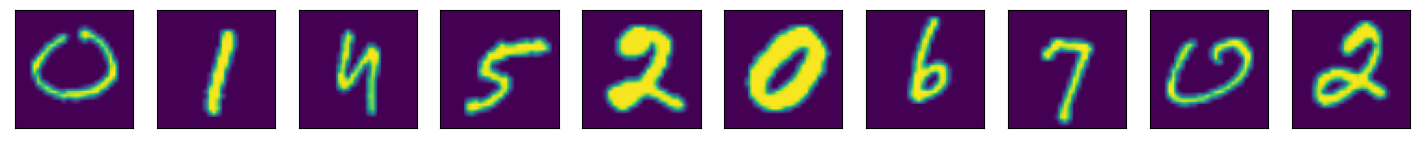

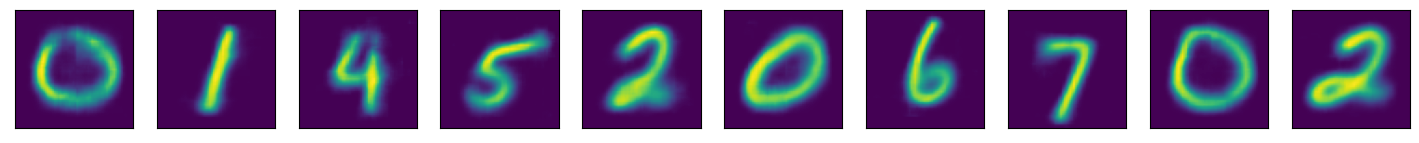

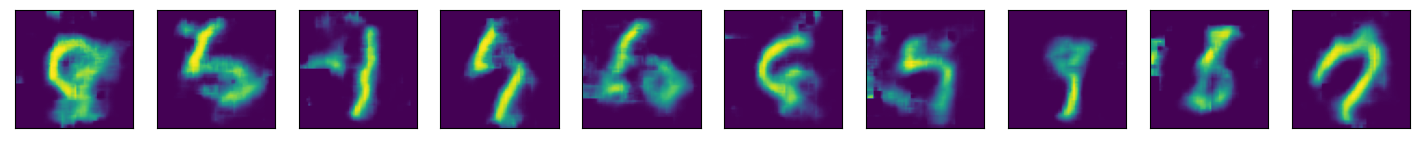

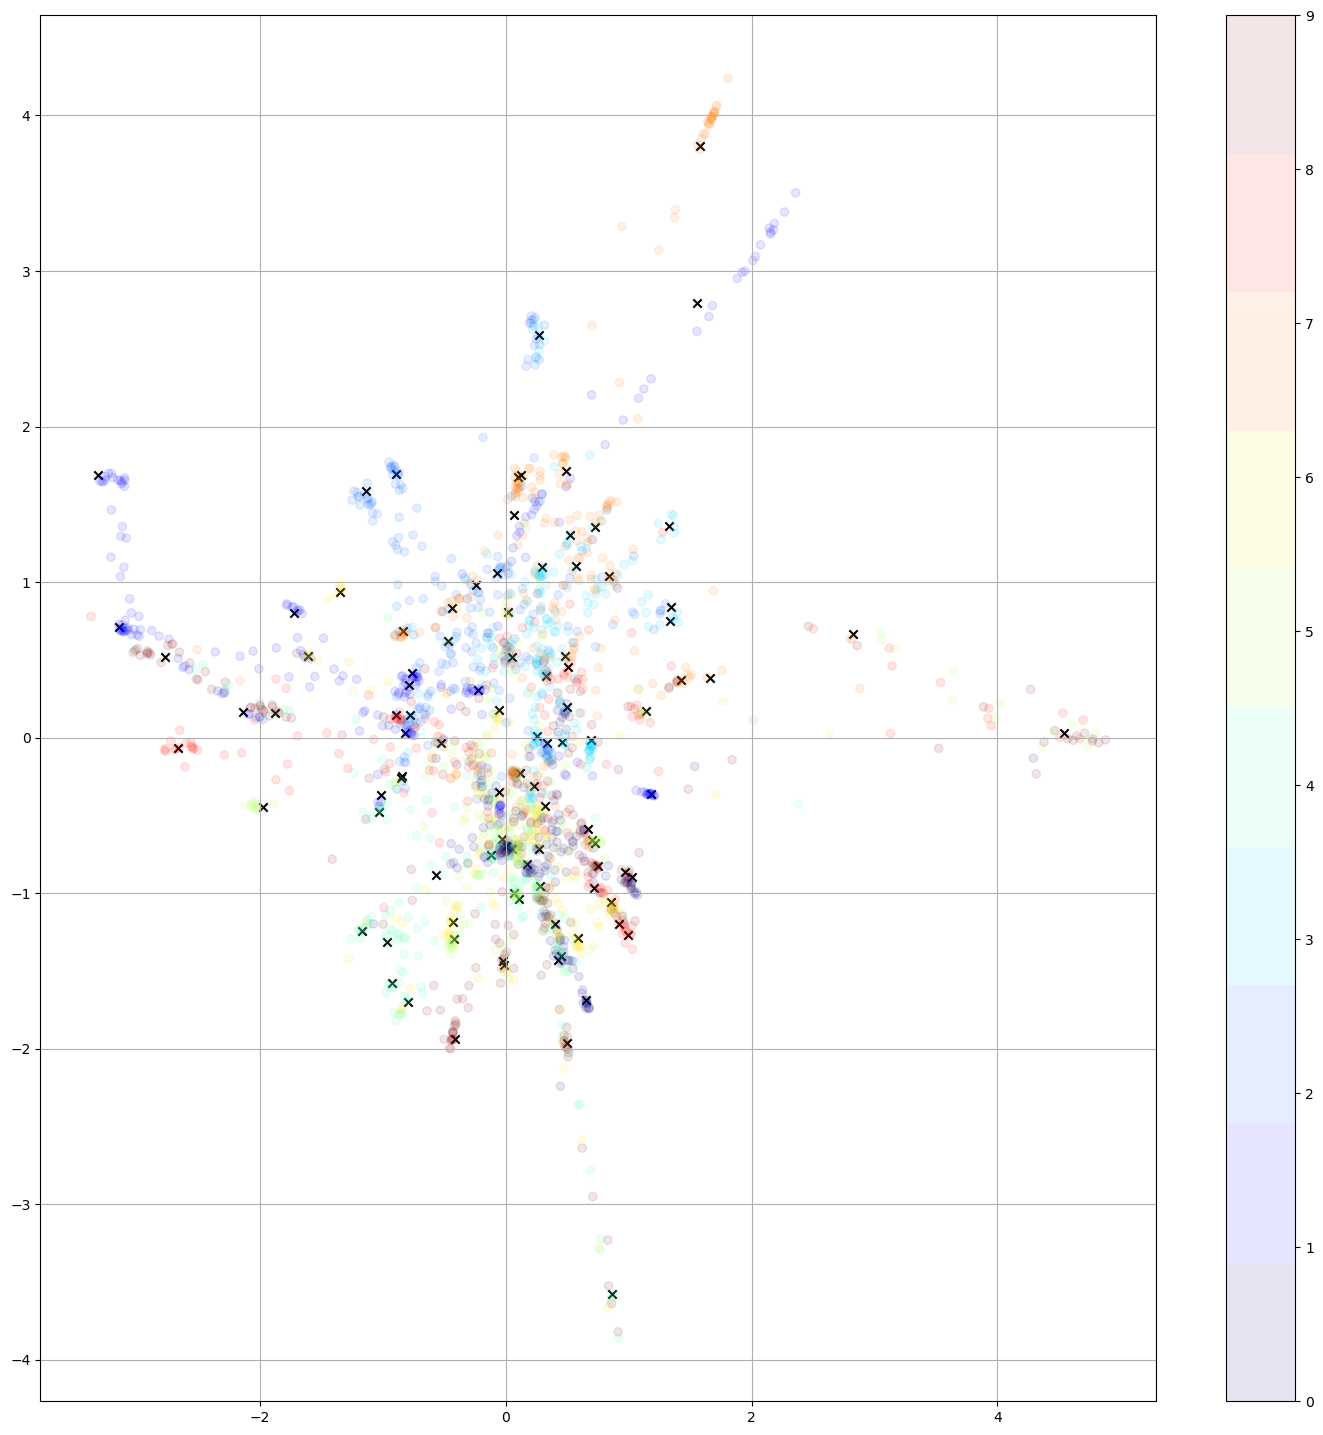

103001
lse_loss -218.6162872314453
recon_loss 0.12504170835018158
103002
lse_loss -250.57530212402344
recon_loss 0.12063604593276978
103003
lse_loss -258.55126953125
recon_loss 0.11279668658971786
103004
lse_loss -241.6470489501953
recon_loss 0.11311548948287964
103005
lse_loss -239.0220489501953
recon_loss 0.1206791028380394
103006
lse_loss -265.53399658203125
recon_loss 0.11964039504528046
103007
lse_loss -255.8157196044922
recon_loss 0.11905740201473236
103008
lse_loss -240.3184356689453
recon_loss 0.11742649972438812
103009
lse_loss -243.24380493164062
recon_loss 0.12179833650588989
103010
lse_loss -269.1979675292969
recon_loss 0.12001689523458481


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()

            batch = next(iter(test_loader))
            data = preprocess(batch)

            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)

            plot(data['x'])
            plot(data['y'])

            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)

            import matplotlib.pyplot as plt
            from sklearn.decomposition import PCA

            pca = PCA(n_components=2) 
            _z = data['z'].data.cpu().numpy()
            pca.fit(_z)
            _z_pca = pca.transform(_z)
            _e = model.prior.prior.data.cpu().numpy()
            _e_pca = pca.transform(_e)
            
            plt.figure(figsize=[18, 18])
            plt.scatter(_e_pca[:, 0], _e_pca[:, 1], c='black', marker='x')
            plt.scatter(_z_pca[:, 0], _z_pca[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

# 

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')